In [47]:
# load and plot dataset
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import h5py
from keras.callbacks import ModelCheckpoint
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy



In [74]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X_train , X_val= X[0:-1,:], X[-1:,:]
	y_train, y_val = y[0:-1], y[-1:]
	X_train, X_val = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]), X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
	model_checkpoint = ModelCheckpoint('bestval.h5','val_loss',1, True)
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True))
# 	model.add(LSTM(neurons, batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True))
# 	model.add(LSTM(neurons, batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True))
# 	model.add(Dense(1))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=1, batch_size=batch_size, verbose=1, shuffle=False,callbacks=[model_checkpoint])
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


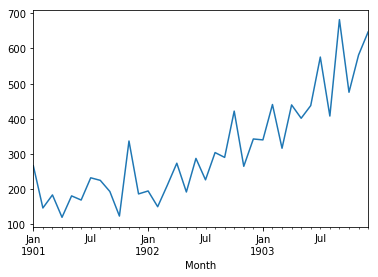

In [88]:
# load dataset
series = read_csv('shamp.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

In [89]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [84]:
diff_values

0    -120.1
1      37.2
2     -63.8
3      61.0
4     -11.8
5      63.3
6      -7.3
7     -31.7
8     -69.9
9     213.6
10   -150.6
11      8.4
12    -44.8
13     60.6
14     63.2
15    -81.9
16     95.6
17    -61.0
18     77.6
19    -13.7
20    131.7
21   -157.1
22     77.8
23     -2.6
24    100.7
25   -124.5
26    123.4
27    -38.0
28     36.1
29    138.1
30   -167.9
31    274.4
32   -206.7
33    106.0
34     65.6
dtype: float64

In [90]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [91]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]


In [92]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


In [ ]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)

In [76]:
# forecast the entire training dataset to build up state for forecasting
lstm_model.load_weights('bestval.h5')
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


array([[-0.31982785],
       [ 0.2708416 ],
       [-0.28509596],
       [ 0.11198568],
       [-0.4584904 ],
       [-0.20609759],
       [-0.59012234],
       [-0.27408659],
       [ 0.01044174],
       [ 0.33311164],
       [-1.03393912],
       [-0.07885348],
       [ 0.06893528],
       [ 0.38770378],
       [-0.14214845],
       [-0.37678668],
       [ 0.33580077],
       [-0.383578  ],
       [ 0.27144063],
       [-0.28459802],
       [ 0.09738186],
       [-0.71272862],
       [ 0.26961201]], dtype=float32)

In [120]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=1, Predicted=330.993848, Expected=339.700000
Month=2, Predicted=417.409343, Expected=440.400000
Month=3, Predicted=423.231184, Expected=315.900000
Month=4, Predicted=463.948282, Expected=439.300000
Month=5, Predicted=429.710081, Expected=401.300000
Month=6, Predicted=512.739361, Expected=437.400000
Month=7, Predicted=516.418641, Expected=575.500000
Month=8, Predicted=515.084776, Expected=407.600000
Month=9, Predicted=532.778030, Expected=682.000000
Month=10, Predicted=538.282049, Expected=475.300000
Month=11, Predicted=536.140898, Expected=581.300000
Month=12, Predicted=572.594539, Expected=646.900000


Test RMSE: 82.682


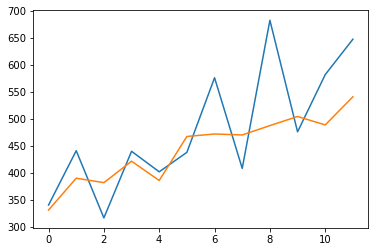

In [78]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

In [105]:
import numpy as np
a = np.zeros((2,2),dtype=np.float64)
b = np.zeros((2,2),dtype=np.float64)

In [112]:
a[1] = 1
a[0] = 2
b[0] = 2.5
b[1] = 4

In [114]:
scale,val,tval = scale(a,b)

In [119]:
invert_scale(scale,val[0][0],tval[0][0])

TypeError: 'numpy.float64' object is not iterable